In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d

from skimage import data, io, color
from skimage.transform import resize

plt.rcParams['figure.figsize'] = [8, 8]

def show_plot(image):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.xticks(np.arange(image.shape[0]))
    plt.yticks(np.arange(image.shape[0]))
    plt.colorbar()
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def linear_to_row_col(index, row_width):
    return (index // row_width, index % row_width)

##### Decimation matrix (row major) - assumes only taking 4 neighbours and that $L = M*2$

In [2]:
# l = 8
# m = 4
# d = l // m

# d_matrix = np.zeros((m**2, l**2))

# tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
# t_len = tile.shape[0]

# for p in np.arange(l//4):
#     p_offset = p * l # 8
#     for q in np.arange(m):
#         d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
#         r_offset = m**2 // 2
#         c_offset = l**2 // 2
#         d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant

In [3]:
# x = np.arange(1, 65) # 1..64
# print(x.reshape(8, 8))

# y = np.matmul(d_matrix * 1/4, x)
# print(y.reshape(4, 4))

##### Sharpening matrix (padded)

In [4]:
# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (100, 100), anti_aliasing=True)
# show_plot(x)

# laplace_deblur = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# scikit_convolved = normalise(convolve2d(x, laplace_deblur, mode="same"))
# show_plot(scikit_convolved)

# l = x.shape[0]
# laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)
# laplacian_dim = laplacian.shape[0]
# padding = laplacian_dim - 1 # s_matrix padding for out of bounds convolution
# laplacian = laplacian.flatten()
# strided_laplacian = np.insert(laplacian, laplacian_dim, np.repeat(0, l-1))
# strided_laplacian = np.insert(strided_laplacian, laplacian_dim*2+l-1, np.repeat(0, l-1))
# s_matrix = np.zeros(((l+padding)**2, (l+padding)**2), dtype=np.float32)

# for sr in np.arange(l):
#     for r in np.arange(l):
#         row_offset = (sr*l)+(l+padding+padding//2)+(padding*sr)
#         col_offset = sr*(l+padding)+r
#         s_matrix[row_offset+r, col_offset:col_offset+strided_laplacian.shape[0]] = strided_laplacian

# show_plot(s_matrix)
        
# x_padded = np.pad(x, 1)
# x_padded = x_padded.reshape(1, x_padded.shape[0]**2)
# x_padded = np.matmul(s_matrix, x_padded.T)
# x_padded = x_padded.reshape(102, 102)[1:101, 1:101]
        
# show_plot(normalise(x_padded))
# show_plot(scikit_convolved - normalise(x_padded))

##### Sharpening matrix (no padding)

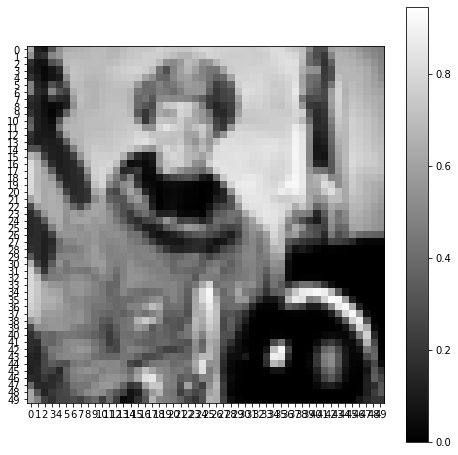

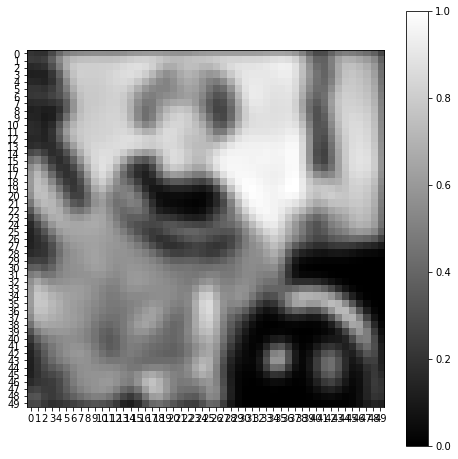

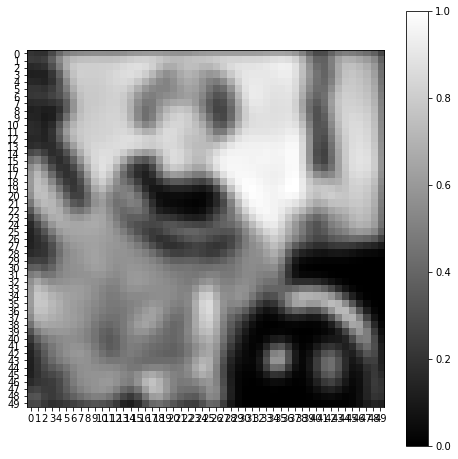

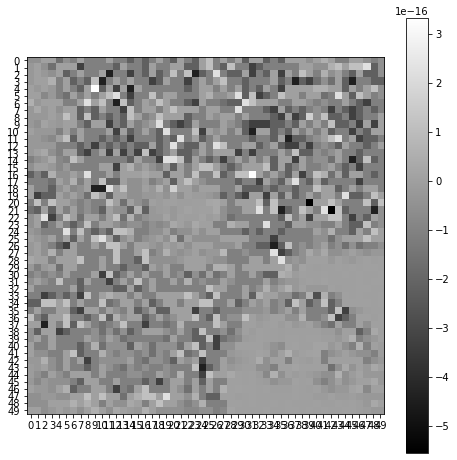

In [19]:
x_true = color.rgb2gray(data.astronaut())
x = resize(x_true, (50, 50), anti_aliasing=True)
show_plot(x)

l = x.shape[0]

s_matrix = np.zeros((l**2, l**2))
# laplace = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
laplace = np.array([[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7], [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]], dtype=np.float32) * 1/273
kernel_dim = laplace.shape[0]
kernel_half_supp = (kernel_dim - 1) // 2

for s_row in np.arange(l**2):
    
    row, col = linear_to_row_col(s_row, l)
    
    for k_row in np.arange(-(kernel_half_supp), kernel_half_supp + 1):
        # map "kernel row" to rows in s_matrix
        mapped_row = row + k_row
        # ignore any out of bounds rows
        if mapped_row >= 0 and mapped_row < l:
            linear_col = col - kernel_half_supp
            # truncate negative columns
            mapped_col_start = max(linear_col, 0)
            # truncate columns which exceed the l dimension
            mapped_col_end = min(linear_col + kernel_dim, l)
            # left trimming for kernels when overlapping out of bounds region in s_matrix (col < 0)
            left = np.absolute(col - kernel_half_supp) if linear_col < 0 else 0
            # right trimming for kernels when overlapping out of bounds region in s_matrix (col >= l)
            right = linear_col + kernel_dim - l if linear_col + kernel_dim >= l else 0 
            # copy over kernel row for current k_row, possibly including trimming for out of bounds coordinates
            s_matrix[s_row][mapped_row * l + mapped_col_start : mapped_row * l + mapped_col_end] = laplace[k_row+kernel_half_supp][left: left + kernel_dim - right]

# s_matrix = np.zeros((l**2, l**2))
# show_plot(s_matrix)

# laplace_deblur = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
scikit_convolved = normalise(convolve2d(x, laplace, mode="same"))
show_plot(scikit_convolved)

x = x.reshape(1, x.shape[0]**2)
x = np.matmul(s_matrix, x.T)
x = x.reshape(50, 50)
        
show_plot(normalise(x))
show_plot(scikit_convolved - normalise(x))